In [762]:
#ideas for importing data:
#1. get data in batches: export to a list, export list to a csv, import csv for each new run - do data preprocessing
#2. get data in batches, process each batch, export to a csv, import csv with specified datatypes
#3. how big is a "big" dataset? whats the general limit for what i can export to work with on my computer?
#4. multithreading vs. multiprocessing?
#5. export data to a database? SQLalchemy
#6. work directly in colab, then download and export to github?

In [747]:
import pandas as pd
import numpy as np
import requests
#python client for Socrata open data API
from sodapy import Socrata
import os
import seaborn as sns
from matplotlib import pyplot as plt
import sys
from fuzzywuzzy import process
from fuzzywuzzy import fuzz
import pygsheets

os.getcwd()
pd.options.display.max_columns=50

In [19]:
#define parameters for endpoint, dataset, and app token
data_url = 'data.cityofnewyork.us'
dataset = 'erm2-nwe9'
app_token = 'dM7DDeidbAmgtydtJVV1epbiU'

#sets up the connection, need application token to override throttling limits
#username and password only required for creating or modifying data
client = Socrata(data_url, app_token)
client.timeout = 6000

#count number of records in desired dataset
record_count = client.get(dataset, select='count(*)', where="created_date >='2019-01-01'")
record_count

[{'count': '3049868'}]

In [20]:
def get_data(chunk_size=100000, total_rows=300000):
    start = 0
    results=[]

    #paginate through dataset in sets of 10000 to get all records since 2019
    while True:
        print(start)
        results.extend(client.get(dataset,where="created_date >= '2019-01-01'", 
                                  limit=chunk_size, offset=start))
        start += chunk_size
        if start > total_rows:
            break
            
#orig_results - all dtypes are objects
#orig_results = pd.DataFrame(results)
#orig_results.to_csv('/Users/christinejiang/Documents/Python/data/311_data.csv', index=False)

0
100000
200000


In [581]:
def old_memory_reduction(dataframe):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
        this is an older method; it does not consider whether there is a low number of unique values in a column 
        in order to warrant use of categorical data type instead of object. 
        basically does manual downcasting; this is uncessary if we use pd.to_numeric(downcast=type)
        also does inplace operation, which we don't want.
    """
    start_mem = dataframe.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in dataframe.columns:
        col_type = dataframe[col].dtype
        
        if col_type != object:
            c_min = dataframe[col].min()
            c_max = dataframe[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    #print(col, col_type, 'int8')
                    dataframe[col] = dataframe[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    #print(col, col_type, 'int16')
                    dataframe[col] = dataframe[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    #print(col, col_type, 'int32')
                    dataframe[col] = dataframe[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    #print(col, col_type, 'int64')
                    dataframe[col] = dataframe[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    #print(col, col_type, 'float16')
                    dataframe[col] = dataframe[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    #print(col, col_type, 'float32')
                    dataframe[col] = dataframe[col].astype(np.float32)
                else:
                    #print(col, col_type, 'float64')
                    dataframe[col] = dataframe[col].astype(np.float64)
        else:
            #print(col, col_type, 'category')
            dataframe[col] = dataframe[col].astype('category')
            
    end_mem = dataframe.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return dataframe

def get_mem_usage(df):
    dtypes = df.dtypes.astype(str).unique()
    total_mem = df.memory_usage().sum()/1024**2
    for dtype in dtypes:
        selected_dtype = df.select_dtypes(include=dtype)
        mean_usage_b = selected_dtype.memory_usage().mean()
        mean_usage_mb = mean_usage_b / 1024**2
        print('avg memory usage for {} columns: {:03.2f} MB'.format(dtype, mean_usage_mb))
    print(f'total memory usage: {total_mem:.2f}')
    
def new_memory_reduction(df):
    """improved version of memory reduction function. uses pd.to_numeric to downcast types;
    also considers whether there are few enough unique values to warrant use of category vs. object."""
    orig_size = df.memory_usage().sum()/1024**2
    dtypes = df.dtypes.astype(str).unique()
    converted_float = pd.DataFrame()
    converted_int = pd.DataFrame()
    converted_obj = pd.DataFrame()
    for dtype in dtypes:
        if 'float' in dtype:
            selected_float = df.select_dtypes(include='float')
            converted_float = selected_float.apply(pd.to_numeric, downcast='float')
            float_size = selected_float.memory_usage().sum()/1024**2
            converted_float_size = converted_float.memory_usage().sum()/1024**2
            print(f'floats: {float_size:.2f} reduced to {converted_float_size:.2f} MB')
        if 'int' in dtype:
            selected_int = df.select_dtypes(include='integer')
            converted_int = selected_int.apply(pd.to_numeric, downcast='integer')
            int_size = selected_int.memory_usage().sum()/1024**2
            converted_int_size = converted_int.memory_usage().sum()/1024**2
            print(f'ints: {int_size:.2f} reduced to {converted_int_size:.2f} MB')
        if 'object' in dtype:
            selected_object = df.select_dtypes(include='object')
            obj_size = selected_object.memory_usage().sum()/1024**2
            for col in selected_object.columns:
                count = len(selected_object[col])
                unique = len(selected_object[col].astype(str).unique())
                if unique < count/2:
                    converted_obj[col] = selected_object[col].astype(str).astype('category')
                else:
                    converted_obj[col] = selected_object[col].astype(str)
            converted_obj_size = converted_obj.memory_usage().sum()/1024**2
            print(f'object: {obj_size:.2f} reduced to {converted_obj_size:.2f} MB')

    float_int = converted_float.join(converted_int)
    reduced_df = float_int.join(converted_obj)
    reduced_df = reduced_df[df.columns]
    reduced_size = reduced_df.memory_usage().sum()/1024**2
    print(f'final df: {orig_size:.2f} reduced to {reduced_size:.2f} MB, {(orig_size-reduced_size)/orig_size*100:.1f}% reduction')
    return reduced_df

def preprocess_df(df):
    cleandf = df.drop(['intersection_street_1',
               'intersection_street_2',
               'taxi_company_borough',
               'taxi_pick_up_location',
               'bridge_highway_name',
               'bridge_highway_direction',
               'road_ramp',
               'bridge_highway_segment',
               'landmark',
               'vehicle_type'], axis=1, inplace=False)

    for col in df.columns:
        if 'date' in col:
            cleandf[col] = pd.to_datetime(newdf[col])
            
    cleandf['created_year'] = [x.year for x in cleandf['created_date']]
    cleandf['created_month'] = [x.month for x in cleandf['created_date']]
    cleandf['created_day'] = [x.day for x in cleandf['created_date']]
    cleandf['created_hour'] = [x.hour for x in cleandf['created_date']]
    cleandf['closed_hour'] = [x.hour for x in cleandf['closed_date']]
    cleandf['time_to_close'] = cleandf['closed_date'] - cleandf['created_date']
    return cleandf

In [568]:
#olddf - most dtypes are objects, some are ints and some are floats
#BUT olddf datatypes get changed inplace after running reduce_mem_usage! becomes mostly categorical
#olddf = pd.read_csv('/Users/christinejiang/Documents/Python/data/311_data.csv')

#newdf - most dtypes are categorical, some ints and floats
newdf = new_memory_reduction(olddf)

cleaneddf = preprocess_df(newdf)

ints: 2.29 reduced to 1.14 MB
object: 80.11 reduced to 48.73 MB
floats: 11.44 reduced to 5.72 MB
final df: 93.84 reduced to 55.59 MB, 40.8% reduction


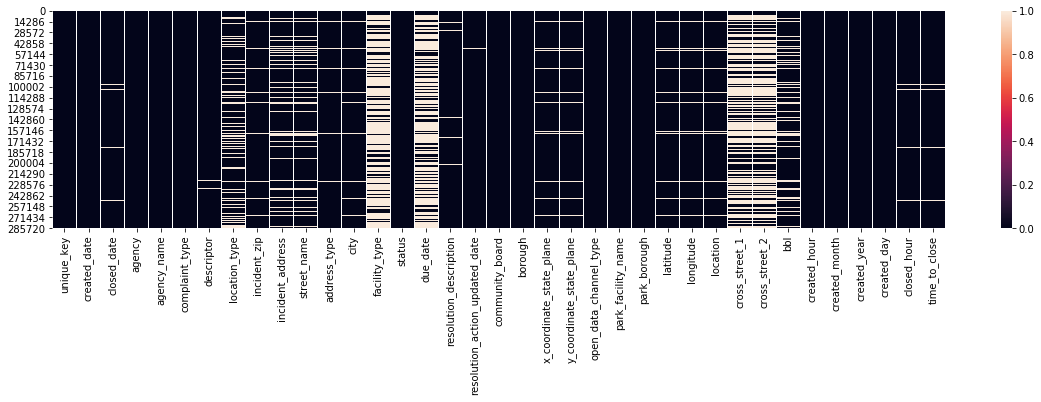

In [699]:
sns.heatmap(cleaned_df.isnull())

In [727]:
#agency name: look at top 10-20
#complaint type: needs to be grouped
#descriptor: needs to be cleaned
#location type: needs to be cleaned
#city: needs to be cleaned
#resolution description: NLP extraction?
#community board: extract last charaters, same as borough
#parks: visualize parks?

valid_location_types = ['Residential Building', 'Street/Sidewalk', 'Property Address','Store/Commercial']
for x in cleaned_df['location_type'][:5]:
    print (x, process.extract(x, valid_location_types, limit=1))

3+ Family Apt. Building [('Residential Building', 54)]
3+ Family Apt. Building [('Residential Building', 54)]
Other (Explain Below) [('Residential Building', 29)]
Commercial Building [('Store/Commercial', 73)]
3+ Family Apt. Building [('Residential Building', 54)]


In [753]:
fuzz.ratio('test', ('test').lower())

100

In [757]:
#for each of the columns, export a csv with the column title and the counts
#in the csv, pick the most common names
for col in ['agency_name', 'complaint_type', 'descriptor', 'location_type','city']:
    counts = cleaned_df[col].value_counts()
    counts.to_csv('')

0                Department of Health and Mental Hygiene
1      Department of Housing Preservation and Develop...
2                        New York City Police Department
3                          Taxi and Limousine Commission
4                           Department of Transportation
5                 Department of Environmental Protection
6                               Department of Sanitation
7                                Department of Buildings
8                                   BCC - Brooklyn South
9                     Department of Parks and Recreation
10                          HRA Benefit Card Replacement
11                        Department of Consumer Affairs
12     Operations Unit - Department of Homeless Services
13                                   BCC - Staten Island
14                                           BCC - Bronx
15                                          A - Brooklyn
16                                         A - Manhattan
17                             

In [794]:
#authorization
gc = pygsheets.authorize(service_file='/Users/christinejiang/Documents/Python/data/client_secret.json')

# Create empty dataframe
df = pd.DataFrame()

# Create a column
df['name'] = ['John', 'Steve', 'Sarah']
df['test'] = ['test','test','test']

#open the google spreadsheet (where 'PY to Gsheet Test' is the name of my sheet)
sh = gc.open('311_data_cleaning')

#select the first sheet 
wks = sh[0]

#update the first sheet with df, starting at cell B2. 
wks.set_dataframe(df,(1,1))

In [792]:
df

,name
0,John
1,Steve
2,Sarah
